In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
sns.set()

# Consumption data analysis

In [2]:
abs_path = '../../../movilens/'

In [3]:
ratings = pd.read_csv(os.path.join(abs_path, 'rating.csv'))
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
ratings['timestamp'].min(), ratings['timestamp'].max()

('1995-01-09 11:46:44', '2015-03-31 06:40:02')

In [5]:
ratings['rating'].mean(), ratings['rating'].min(), ratings['rating'].max()

(3.5255285642993797, 0.5, 5.0)

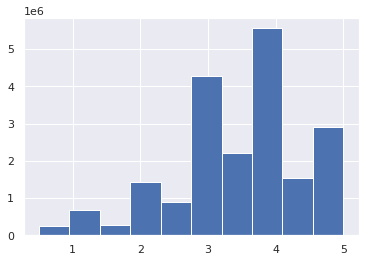

In [6]:
plt.hist(ratings['rating']);

In [7]:
ratings['liked'] = (ratings['rating']>=3.5).astype(int)

In [8]:
ratings['liked'].value_counts()

1    12195566
0     7804697
Name: liked, dtype: int64

In [9]:
ratings['rating'] = ratings['rating'].astype('float16')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float16
 3   timestamp  object 
 4   liked      int64  
dtypes: float16(1), int64(3), object(1)
memory usage: 648.5+ MB


In [10]:
ratings.shape

(20000263, 5)

In [11]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

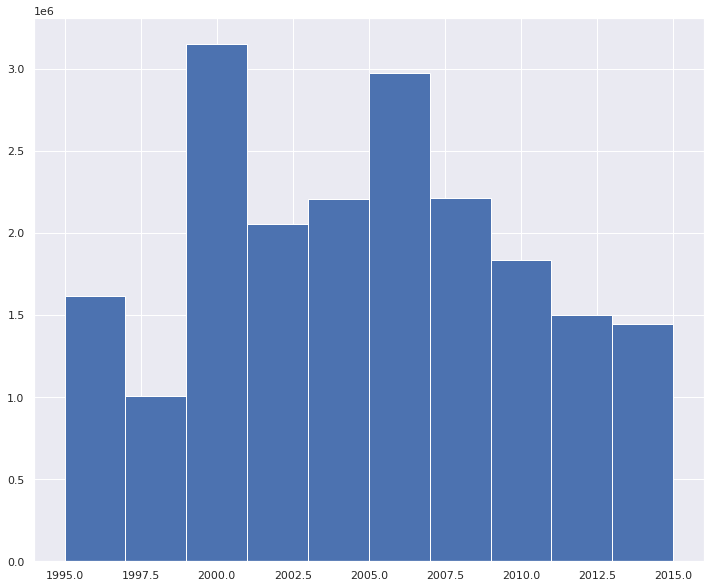

In [12]:
plt.figure(figsize=(12,10))
plt.hist(ratings['timestamp'].dt.year);

In [13]:
num_movies = dict(ratings.movieId.value_counts())

# Metadata analysis

In [14]:
import json
from collections import Counter

In [15]:
movies_meta = pd.read_csv('../processed_data/metadata.csv')

In [16]:
movies_meta.head()

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes
0,1,Toy Story (1995),"['Children', 'Adventure', 'Comedy', 'Animation...","['3d', 'action', 'adventure', 'affectionate', ...",tt0114709,"['Tim Allen', 'John Ratzenberger', 'Wallace Sh...",movie,0,1995,8.3,872273
1,2,Jumanji (1995),"['Children', 'Adventure', 'Comedy', 'Family', ...","['action', 'adventure', 'animal movie', 'anima...",tt0113497,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",movie,0,1995,7.0,302198
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']","['chase', 'comedy', 'destiny', 'family', 'good...",tt0113228,"['Richard C. Berman', 'John Campbell', 'Monica...",movie,0,1995,6.7,23870
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']","['feel good movie', 'feel-good', 'friendship',...",tt0114885,"['Whitney Houston', 'Gregory Hines', ""Kenneth ...",movie,0,1995,5.9,9412
4,5,Father of the Bride Part II (1995),"['Comedy', 'Romance', 'Family']","['chase', 'comedy', 'cute!', 'destiny', 'famil...",tt0113041,"['Rodrigo Botero', 'William Akey', 'Sam Anders...",movie,0,1995,6.1,33982


In [19]:
movies_meta['startYear'].isna().sum()

0

### working with genres

In [20]:
genres = np.hstack(movies_meta['genres'].apply(lambda x: json.loads(x.replace("'", '"'))))

In [21]:
genres, counts = zip(*sorted(Counter(genres).items(), key = lambda x: x[1]))

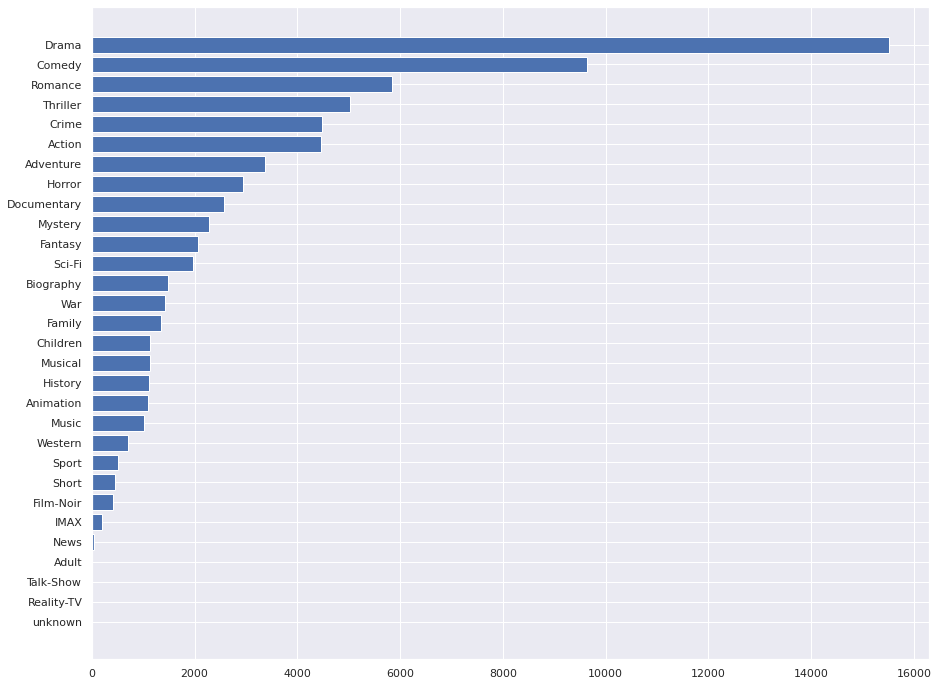

In [22]:
plt.figure(figsize=(15,12))
plt.barh(range(len(genres)), counts)
plt.yticks(range(len(genres)),genres);

In [23]:
movies_meta['counts'] = movies_meta['movieId'].map(num_movies)

### defining the feature list

In [24]:
features = ['startYear', 'titleType', 'genres']

### working with isAdult

In [25]:
movies_meta.groupby('isAdult').agg({'counts' : 'sum'})

,counts
isAdult,
0,19995391.0
1,4872.0


### working with titleType

In [26]:
movies_meta.groupby('titleType').agg({'counts' : 'sum'})

,counts
titleType,
movie,19816320.0
short,57453.0
tvEpisode,7425.0
tvMiniSeries,29171.0
tvMovie,36888.0
tvSeries,2864.0
tvShort,2938.0
tvSpecial,4914.0
video,42290.0


In [27]:
movies_meta['titleType'].value_counts()

movie           24560
tvMovie          1033
video             659
short             547
tvMiniSeries      216
tvSpecial         100
tvEpisode          78
tvShort            59
tvSeries           26
Name: titleType, dtype: int64

In [28]:
def aggregate_tv(x):
    if x.startswith('tv'):
        return 'tv'
    else:
        return x

### working with years

In [29]:
start_year_vals = movies_meta.groupby('startYear').agg({'counts' : 'sum'}).sort_values(by='startYear')

<AxesSubplot:xlabel='startYear'>

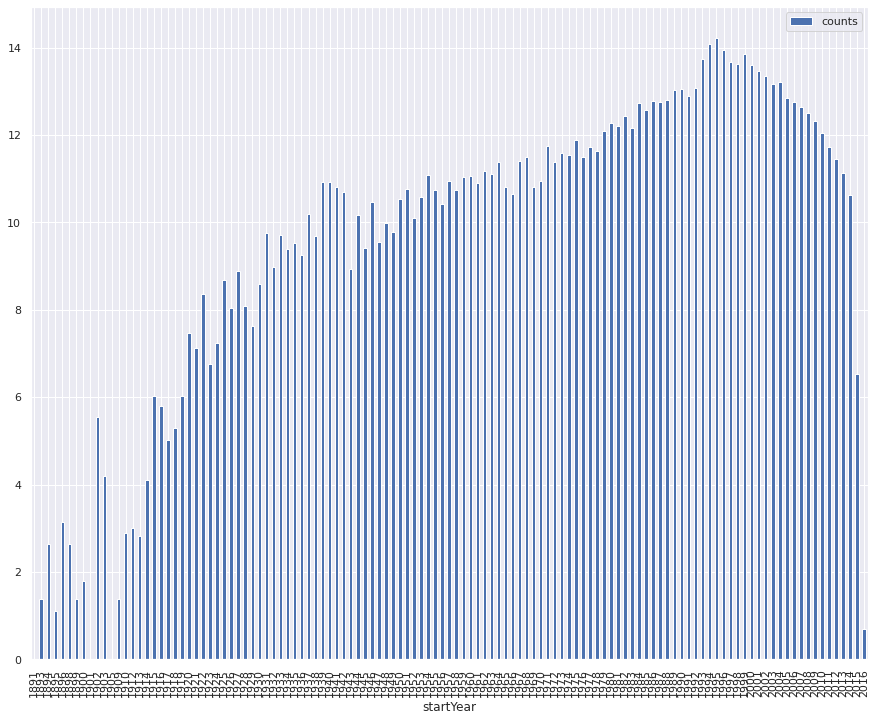

In [30]:
np.log(start_year_vals).plot.bar(figsize=(15,12))

In [31]:
(movies_meta['startYear'].max()-movies_meta['startYear'].min())/5

25.0

In [54]:
def map_dates(x):
    x = int(x)
    if x>=1891 and x<1916:
        return '1891-1916'
    if x>=1916 and x<1941:
        return '1916-1941'
    if x>=1941 and x<1966:
        return '1941-1966'
    if x>=1966 and x<1991:
        return '1966-1991'
    if x>=1991 and x<=2016:
        return '1991-2016'


### working with titles

In [55]:
title_tokens = movies_meta['title'].apply(lambda x: [i for i in x.split(' ') if i][:-1]).values

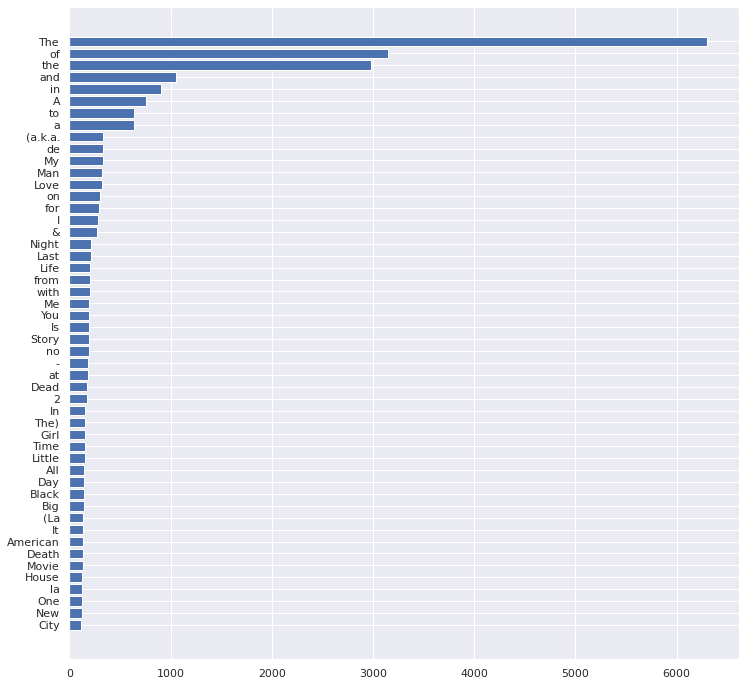

In [56]:
tokens, counts = np.unique(np.hstack(title_tokens), return_counts=True)
top50 = sorted(dict(zip(tokens,counts)).items(), key = lambda x: x[1], reverse=True)[:50]
top50tokens, top50counts = zip(*top50)
plt.figure(figsize=(12,12))
plt.barh(range(len(top50tokens)), top50counts[::-1])
plt.yticks(range(len(top50tokens)), top50tokens[::-1], rotation=0);

In [57]:
len(tokens)

29902

# Feature generation

In [58]:
features_df = movies_meta.copy()

In [59]:
features_df.head()

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes,counts
0,1,Toy Story (1995),"['Children', 'Adventure', 'Comedy', 'Animation...","['3d', 'action', 'adventure', 'affectionate', ...",tt0114709,"['Tim Allen', 'John Ratzenberger', 'Wallace Sh...",movie,0,1995,8.3,872273,49695.0
1,2,Jumanji (1995),"['Children', 'Adventure', 'Comedy', 'Family', ...","['action', 'adventure', 'animal movie', 'anima...",tt0113497,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",movie,0,1995,7.0,302198,22243.0
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']","['chase', 'comedy', 'destiny', 'family', 'good...",tt0113228,"['Richard C. Berman', 'John Campbell', 'Monica...",movie,0,1995,6.7,23870,12735.0
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']","['feel good movie', 'feel-good', 'friendship',...",tt0114885,"['Whitney Houston', 'Gregory Hines', ""Kenneth ...",movie,0,1995,5.9,9412,2756.0
4,5,Father of the Bride Part II (1995),"['Comedy', 'Romance', 'Family']","['chase', 'comedy', 'cute!', 'destiny', 'famil...",tt0113041,"['Rodrigo Botero', 'William Akey', 'Sam Anders...",movie,0,1995,6.1,33982,12161.0


In [60]:
features_df['startYear'].isna().sum()

0

In [61]:
features_df['startYear'].max(), features_df['startYear'].min()

(2016, 1891)

### feature from startYear

In [62]:
features_df['startYear'] = features_df['startYear'].apply(map_dates)

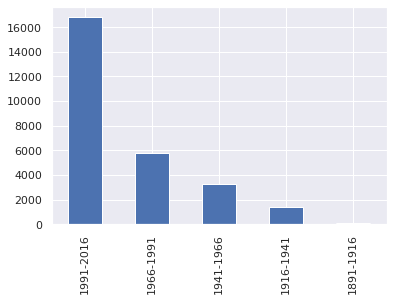

In [63]:
features_df['startYear'].value_counts().plot.bar();

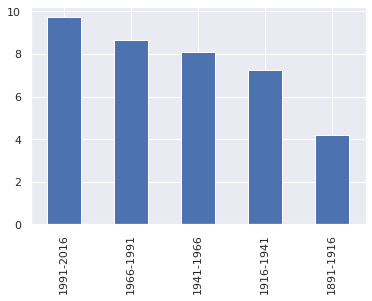

In [64]:
np.log1p(features_df['startYear'].value_counts()).plot.bar();

### feature from tv

In [65]:
features_df['titleType'] = features_df['titleType'].apply(aggregate_tv)

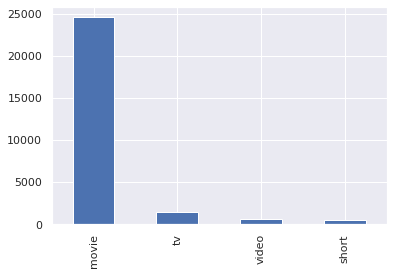

In [66]:
features_df['titleType'].value_counts().plot.bar();

In [67]:
features_df.head()

,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes,counts
0,1,Toy Story (1995),"['Children', 'Adventure', 'Comedy', 'Animation...","['3d', 'action', 'adventure', 'affectionate', ...",tt0114709,"['Tim Allen', 'John Ratzenberger', 'Wallace Sh...",movie,0,1991-2016,8.3,872273,49695.0
1,2,Jumanji (1995),"['Children', 'Adventure', 'Comedy', 'Family', ...","['action', 'adventure', 'animal movie', 'anima...",tt0113497,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",movie,0,1991-2016,7.0,302198,22243.0
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']","['chase', 'comedy', 'destiny', 'family', 'good...",tt0113228,"['Richard C. Berman', 'John Campbell', 'Monica...",movie,0,1991-2016,6.7,23870,12735.0
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']","['feel good movie', 'feel-good', 'friendship',...",tt0114885,"['Whitney Houston', 'Gregory Hines', ""Kenneth ...",movie,0,1991-2016,5.9,9412,2756.0
4,5,Father of the Bride Part II (1995),"['Comedy', 'Romance', 'Family']","['chase', 'comedy', 'cute!', 'destiny', 'famil...",tt0113041,"['Rodrigo Botero', 'William Akey', 'Sam Anders...",movie,0,1991-2016,6.1,33982,12161.0


In [68]:
features_df.isna().sum()

movieId            0
title              0
genres             0
tags               0
imdbId             0
primaryName        0
titleType          0
isAdult            0
startYear          0
averageRating      0
numVotes           0
counts           534
dtype: int64

In [69]:
if not os.path.exists('../processed_data'):
    os.mkdir('../processed_data')

In [70]:
features_df.to_csv('../processed_data/meta_features.csv')

In [71]:
features_df = features_df[features+['movieId']]

# Feature processing

In [72]:
from sklearn.preprocessing import MultiLabelBinarizer
import json

In [73]:
startYear_feature = pd.get_dummies(features_df['startYear'])

In [74]:
titleType_feature = pd.get_dummies(features_df['titleType'])

In [75]:
features_df['genres'] = features_df['genres'].apply(lambda x: json.loads(x.replace("'",'"')))

In [76]:
classes = np.unique(np.hstack(features_df['genres'].values))

In [77]:
classes

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
       'unknown'], dtype='<U11')

In [78]:
genres_encoder = MultiLabelBinarizer(classes=classes)
genres_feature = genres_encoder.fit_transform(features_df['genres'])
genres_feature = pd.DataFrame(genres_feature, columns=classes)

In [79]:
features_df = pd.concat([features_df['movieId'].to_frame(), genres_feature, startYear_feature, titleType_feature], axis=1)

In [80]:
import os

In [81]:
features_df.to_csv('../processed_data/item_features.csv', index=False)